# Поиск изображений по запросу

Задача заключается в разработке демонстрационной версии поиска изображений по запросу.

Для демонстрационной версии необходимо обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

## Описание данных

Данные лежат в папке `/datasets/image_search/`.

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.5 MB/s 
     |████████████████████████████████| 7.6 MB 63.4 MB/s 
     |████████████████████████████████| 182 kB 81.2 MB/s 


In [ ]:
import glob
import os
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import torch
import torchvision.models as models
import transformers
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupShuffleSplit, cross_val_score, StratifiedKFold
from tqdm import notebook
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from torchvision import transforms

Загружаю датасет:

In [ ]:
# данные были загружены на виртуальную машину Google Colab в папку to_upload

In [ ]:
!ls -la

total 147476
drwxr-xr-x 1 root root      4096 Dec 20 11:55 .
drwxr-xr-x 1 root root      4096 Dec 20 11:49 ..
drwxr-xr-x 4 root root      4096 Dec 16 21:14 .config
-rw-r--r-- 1 root root 150987455 Aug 24 14:59 data.zip
drwxr-xr-x 3 root root      4096 Dec 20 11:55 __MACOSX
drwxr-xr-x 1 root root      4096 Dec 16 21:15 sample_data
drwxr-xr-x 4 root root      4096 Jul 24 20:11 to_upload


In [ ]:
BASE_PATH = 'to_upload'
SEED = 12345

## Исследовательский анализ данных

In [ ]:
# функция для получения общей информации
def get_info(df):
    print(df.shape)
    display(df.head())
    print(df.isna().sum())

### Обучающие данные

In [ ]:
train_image_info = pd.read_csv(f'{BASE_PATH}/train_dataset.csv')

In [ ]:
get_info(train_image_info)

(5822, 3)


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


image         0
query_id      0
query_text    0
dtype: int64


In [ ]:
train_image_info['image'].unique().shape

(1000,)

In [ ]:
train_image_info['query_text'].unique().shape

(977,)

In [ ]:
# загрузка изображений
def load_dataset(path):
    for p in glob.glob(f'{path}/*.jpg'):
        img = load_img(p)
        yield img_to_array(img)

In [ ]:
train_images = load_dataset(BASE_PATH + '/train_images')

In [ ]:
def show_img(img_generator):
    fig = plt.figure(figsize=(10,10))
    for i in range(12):
        img = next(img_generator)
        fig.add_subplot(4, 4, i+1)
        plt.imshow(img / 255.)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

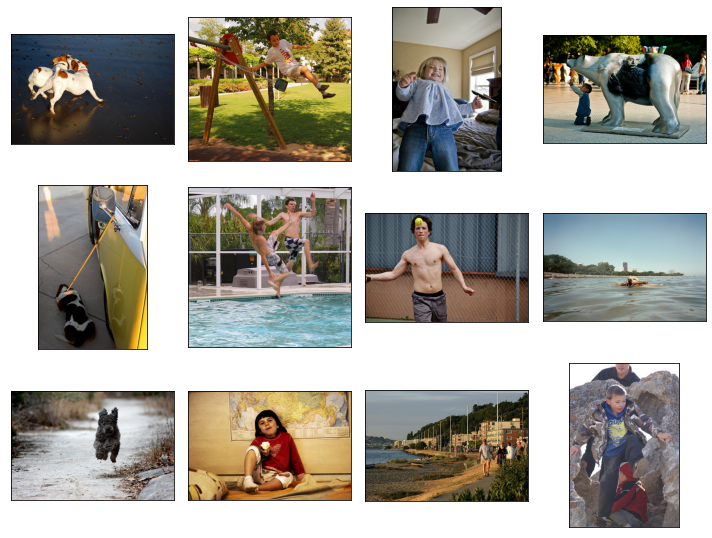

In [ ]:
show_img(train_images)

**Вывод:** в обучающем датасете `train_image_info` содержится 5822 записей с именем изображения, идентификатором описания и текстом описания. Уникальных изображений в датасете - 1000 штук, а уникальных запросов - 977. Также можно отметить, что все изображения разного размера и разной ориентации.

In [ ]:
names_col_crowd = ['image', 'query_id', 'true_votes_share','true_votes', 'false_votes']

In [ ]:
# загрузка файла с данными по соответствию изображения и описания, полученные с помощью краудсорсинга
crowd_annotations = pd.read_csv(f'{BASE_PATH}/CrowdAnnotations.tsv', delimiter='\t', names=names_col_crowd)

In [ ]:
get_info(crowd_annotations)

(47830, 5)


,image,query_id,true_votes_share,true_votes,false_votes
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


image               0
query_id            0
true_votes_share    0
true_votes          0
false_votes         0
dtype: int64


In [ ]:
crowd_annotations.describe()

,true_votes_share,true_votes,false_votes
count,47830.000000,47830.000000,47830.000000
mean,0.068786,0.208488,2.820155
std,0.207532,0.628898,0.656676
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,0.000000,3.000000
max,1.000000,5.000000,6.000000


In [ ]:
crowd_annotations.loc[crowd_annotations['true_votes'] + crowd_annotations['false_votes'] > 3].shape

(1050, 5)

In [ ]:
names_col_expert = ['image', 'query_id', 'expert_1','expert_2', 'expert_3']

In [ ]:
# загрузка файла с данными по соответствию изображения и описания, полученные в результате опроса экспертов
expert_annotations = pd.read_csv(f'{BASE_PATH}/ExpertAnnotations.tsv', delimiter='\t', names=names_col_expert)

In [ ]:
get_info(expert_annotations)

(5822, 5)


,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


image       0
query_id    0
expert_1    0
expert_2    0
expert_3    0
dtype: int64


**Вывод:** эксперты оценили 5822 наборов изображение-описание; крауды дали оценку для 47830 наборов, при этом есть 1050 наборов, где количество оценивающих краудов составило более трех человек (максимум 6).

### Тестовые данные

In [ ]:
test_image_info = pd.read_csv(f'{BASE_PATH}/test_queries.csv', delimiter='|')

In [ ]:
get_info(test_image_info)

(500, 4)


,Unnamed: 0,query_id,query_text,image
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


Unnamed: 0    0
query_id      0
query_text    0
image         0
dtype: int64


In [ ]:
test_image_info['image'].unique().shape

(100,)

In [ ]:
test_image_info['query_text'].unique().shape

(500,)

In [ ]:
test_images = load_dataset(BASE_PATH + '/test_images')

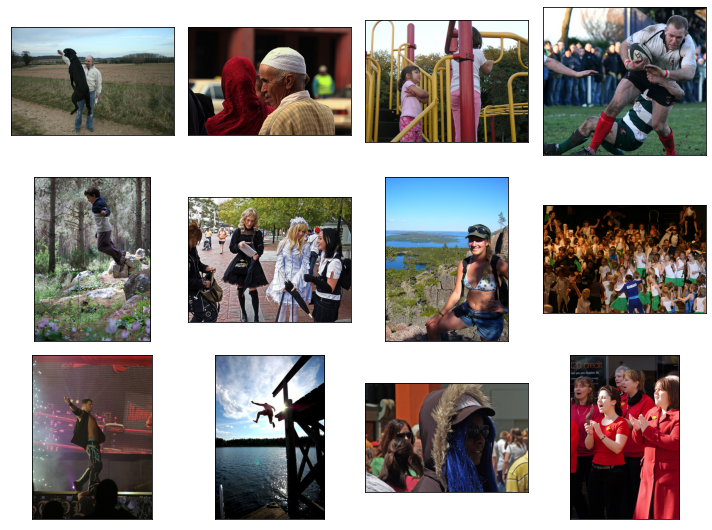

In [ ]:
show_img(test_images)

**Вывод:** в тестовом датасете `test_image_info` содержится 500 записей с именем изображения, идентификатором описания, текстом описания, а так же присутствует колонка `Unnamed: 0	`. Уникальных изображений в датасете - 100 штук, а уникальных запросов - 500.

## Предобработка данных

Датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи необходимо эти оценки агрегировать — превратить в одну.

В файле с краудсорсинговыми оценками информация расположена в следующем порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок нужно выбрать либо одну из них, либо объединить их в одну по критерию: оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

In [ ]:
expert_annotations['experts_rating'] = np.nan

In [ ]:
expert_annotations.head()

,image,query_id,expert_1,expert_2,expert_3,experts_rating
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,NaN
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,NaN
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,NaN
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,NaN
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,NaN


In [ ]:
def aggregation_ratings(row):
    answers = defaultdict(int)
    for column in ['expert_1', 'expert_2', 'expert_3']:
        answers[row[column]] += 1

    if max(answers.values()) > 1:
        row['experts_rating'] = (max(answers, key=answers.get) - 1) / 3

    return row


expert_annotations = expert_annotations.apply(aggregation_ratings, axis=1)

In [ ]:
expert_annotations.isna().sum()

image               0
query_id            0
expert_1            0
expert_2            0
expert_3            0
experts_rating    126
dtype: int64

In [ ]:
expert_annotations.head()

,image,query_id,expert_1,expert_2,expert_3,experts_rating
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,0.000000
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,0.000000
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,0.333333
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,0.000000


In [ ]:
expert_annotations = expert_annotations.dropna()

In [ ]:
expert_annotations.shape

(5696, 6)

In [ ]:
annotations = crowd_annotations[['image', 'query_id', 'true_votes_share']].merge(
    expert_annotations[['image', 'query_id', 'experts_rating']], how='outer', on=['query_id', 'image']
)

In [ ]:
annotations.head()

,image,query_id,true_votes_share,experts_rating
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,NaN
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,NaN
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,NaN
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,NaN
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,NaN


In [ ]:
annotations.isna().sum()

image                   0
query_id                0
true_votes_share     3438
experts_rating      45572
dtype: int64

In [ ]:
annotations['target'] = np.nan

In [ ]:
def make_target(row):
    if not pd.isnull(row['experts_rating']) and not pd.isnull(row['true_votes_share']):
    row['target'] = 0.6*row['experts_rating'] + 0.4*row['true_votes_share']
    elif not pd.isnull(row['experts_rating']):
    row['target'] = row['experts_rating']
    elif not pd.isnull(row['true_votes_share']):
    row['target'] = row['true_votes_share']
    return row

In [ ]:
annotations = annotations.apply(make_target, axis=1)

In [ ]:
train_image_info.shape

(5822, 3)

In [ ]:
annotations.isna().sum()

image                   0
query_id                0
true_votes_share     3438
experts_rating      45572
target                  0
dtype: int64

In [ ]:
annotations[['image', 'query_id', 'target']].shape

(51268, 3)

In [ ]:
train_image_info[['query_text', 'query_id']].shape

(5822, 2)

In [ ]:
train = annotations[['image', 'query_id', 'target']].merge(
    train_image_info[['query_text', 'query_id']].drop_duplicates(), how='inner', on='query_id'
)

In [ ]:
train

,image,query_id,target,query_text
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,"A woman is signaling is to traffic , as seen f..."
1,2182488373_df73c7cc09.jpg,1056338697_4f7d7ce270.jpg#2,0.000000,"A woman is signaling is to traffic , as seen f..."
2,2594042571_2e4666507e.jpg,1056338697_4f7d7ce270.jpg#2,0.000000,"A woman is signaling is to traffic , as seen f..."
3,2843695880_eeea6c67db.jpg,1056338697_4f7d7ce270.jpg#2,0.000000,"A woman is signaling is to traffic , as seen f..."
4,2892995070_39f3c9a56e.jpg,1056338697_4f7d7ce270.jpg#2,0.000000,"A woman is signaling is to traffic , as seen f..."
...,...,...,...,...
50154,422763475_0bc814dac6.jpg,3108732084_565b423162.jpg#2,0.333333,a snowboarder
50155,96420612_feb18fc6c6.jpg,3108732084_565b423162.jpg#2,0.000000,a snowboarder
50156,2985679744_75a7102aab.jpg,3108732084_565b423162.jpg#2,0.000000,a snowboarder
50157,3745451546_fc8ec70cbd.jpg,3108732084_565b423162.jpg#2,0.000000,a snowboarder


In [ ]:
train.shape

(50159, 4)

## Проверка данных

В некоторых странах действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

При попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако, нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [ ]:
train['query_text'].unique()[:20]

array(['A woman is signaling is to traffic , as seen from behind .',
       'A boy in glasses is wearing a red shirt .',
       'A young boy holds onto a blue handle on a pier .',
       'A woman wearing black clothes , a purple scarf , and a pink hat is riding a bike .',
       'An older woman with blond hair rides a bicycle down the street .',
       'A woman wearing a white glove peers over the crowd .',
       'A man taking a picture with a silver camera .',
       'A woman crosses the street near a man , who is on his cellphone .',
       'A man wearing a black shirt and baseball cap smiling .',
       'A woman wears sunglasses and a black coat as she walks .',
       'A little girl wearing a pink shirt jumps off a swing .',
       'a young girl wearing blue smiles .',
       'A young child is wearing blue goggles and sitting in a float in a pool .',
       'A young boy wearing a blue and red hat is using a camera near a swing set .',
       'A smiling boy in an orange shirt with 

После анализа поисковых запросов были выявлены следующие стоп-слова:

In [ ]:
black_list = {'little', 'girl', 'boy', 'young', 'child', 'kid', 'baby'}

In [ ]:
lemmatizer = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
lemmas_cache = {}

def filter_row(row):
    word_list = lemmas_cache.get(row['query_id'])
    if not word_list:
        lemmas = lemmatizer(row['query_text'])
        word_list = {word.lemma_ for word in lemmas}
        lemmas_cache[row['query_id']] = word_list
    row['restricted'] = True if word_list & black_list and row['target'] >= 0.5 else False
    return row

In [ ]:
train = train.apply(filter_row, axis=1)

In [ ]:
train.query('restricted == True').shape

(548, 5)

In [ ]:
train = train.query('restricted == False').reset_index(drop=True)
train.shape

(49611, 5)

In [ ]:
target = train['target']

## Векторизация изображений

Далее векторизую изображения с помощью сверточной нейросети ResNet-18, предварительно натренированной на датасете ImageNet.

In [ ]:
resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad_(False)
    
modules = list(resnet.children())[:-1]
modules.append(torch.nn.Flatten())
resnet = torch.nn.Sequential(*modules)
resnet.eval()

In [ ]:
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
]) 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Run model on', device)
resnet = resnet.to(device)

Run model on cuda


In [ ]:
def images_to_vectors(model, base_path, df):
    img_vectors = []
    cache = {}
    
    for path in notebook.tqdm(df['image']):
        output_vector = cache.get(path)
        if output_vector is None:
            img = Image.open(f'{base_path}/{path}').convert('RGB')
            image_tensor = preprocess(img)
            image_tensor = image_tensor.unsqueeze(0).to(device)
            output_vector = resnet(image_tensor).flatten()
            cache[path] = output_vector

        img_vectors.append(output_vector)
    
    return torch.stack(img_vectors).cpu().detach().numpy()

In [ ]:
img_vectors = images_to_vectors(resnet, BASE_PATH + '/train_images', train)
img_vectors.shape

  0%|          | 0/49611 [00:00<?, ?it/s]

(49611, 512)

## Векторизация текстов

Для векторизации текстов буду использовать предобученный BERT.

In [ ]:
model_class = transformers.BertModel
tokenizer_class = transformers.BertTokenizer
pretrained_weights = 'bert-base-uncased'

# загрузка предобученной модели/токенизатора 
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model_bert = model_class.from_pretrained(pretrained_weights)
model_bert.to(device)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
tokens_cache = {}


def apply_tokenizer(value):
    if value in tokens_cache:
    return tokens_cache[value]
    tokens = tokenizer.encode(value, add_special_tokens=True, truncation=True)
    tokens_cache[value] = tokens
    return tokens

In [ ]:
max_len = train['query_text'].str.len().max()
tokenized = train['query_text'].apply(apply_tokenizer)      
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)
display(padded.shape, attention_mask.shape)

(49611, 153)

(49611, 153)

In [ ]:
batch_size = 50
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size + 1)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model_bert(batch.to(device), attention_mask=attention_mask_batch.to(device))
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/993 [00:00<?, ?it/s]

In [ ]:
# матрица признаков
features_bert = np.concatenate(embeddings)

In [ ]:
features_bert.shape

(49611, 768)

## Объединение векторов

Объединю векторы изображений и векторы текстов с целевой переменной.

In [ ]:
features = np.concatenate((img_vectors, features_bert), axis=1)
features = pd.DataFrame(features, columns=[f'col{i}' for i in range(features.shape[1])])

In [ ]:
print(features.shape, train.shape)

(49611, 1280) (49611, 5)


In [ ]:
merged_df = train.join(features)

In [ ]:
print(merged_df.shape)

(49611, 1285)


In [ ]:
merged_df.head()

,image,query_id,target,query_text,restricted,col0,col1,col2,col3,col4,...,col1270,col1271,col1272,col1273,col1274,col1275,col1276,col1277,col1278,col1279
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,"A woman is signaling is to traffic , as seen f...",False,0.693983,3.031818,2.916986,0.951920,0.936226,...,-0.236315,-0.05761,-0.168587,0.175084,-0.156739,0.737393,0.258654,-0.012605,0.019074,0.162476
1,2182488373_df73c7cc09.jpg,1056338697_4f7d7ce270.jpg#2,0.0,"A woman is signaling is to traffic , as seen f...",False,0.069861,4.210075,0.766443,0.768752,0.043306,...,-0.236315,-0.05761,-0.168587,0.175084,-0.156739,0.737393,0.258654,-0.012605,0.019074,0.162476
2,2594042571_2e4666507e.jpg,1056338697_4f7d7ce270.jpg#2,0.0,"A woman is signaling is to traffic , as seen f...",False,0.159627,1.551687,0.837331,0.725220,0.104743,...,-0.236315,-0.05761,-0.168587,0.175084,-0.156739,0.737393,0.258654,-0.012605,0.019074,0.162476
3,2843695880_eeea6c67db.jpg,1056338697_4f7d7ce270.jpg#2,0.0,"A woman is signaling is to traffic , as seen f...",False,0.562515,0.063395,0.105744,0.510712,0.445310,...,-0.236315,-0.05761,-0.168587,0.175084,-0.156739,0.737393,0.258654,-0.012605,0.019074,0.162476
4,2892995070_39f3c9a56e.jpg,1056338697_4f7d7ce270.jpg#2,0.0,"A woman is signaling is to traffic , as seen f...",False,0.322125,0.411019,0.828816,0.093953,0.861549,...,-0.236315,-0.05761,-0.168587,0.175084,-0.156739,0.737393,0.258654,-0.012605,0.019074,0.162476


## Обучение модели предсказания соответствия

Разобъю исходный датасет на тренировочную и тестовую выборки с помощью `GroupShuffleSplit`, чтобы избежать попадание одной и той же картинки в обе выборки.

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=SEED)

train_indices, test_indices = next(
    gss.split(
        X=merged_df.drop(columns=['target', 'query_id', 'query_text', 'restricted']),
        y=merged_df['target'], 
        groups=merged_df['image']
    )
)
train_df, test_df = merged_df.loc[train_indices], merged_df.loc[test_indices]

In [ ]:
features_train = train_df.drop(columns=['target', 'query_id', 'query_text', 'restricted', 'image'])
target_train = train_df['target']

features_test = test_df.drop(columns=['target', 'query_id', 'query_text', 'restricted', 'image'])
target_test = test_df['target']

In [ ]:
print(
    features_train.shape,
    target_train.shape,
    features_test.shape,
    target_test.shape
)

(34889, 1280) (34889,) (14722, 1280) (14722,)


In [ ]:
def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    model = Sequential()
    model.add(Dense(640, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(Dense(320, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.build()
    model.compile(
        optimizer=optimizer, 
        loss='mse',
        metrics=['mse']
    )
    print(model.summary())
    
    return model

In [ ]:
neuro_model = create_model((features_train.shape[1], ))

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_107 (Dense)           (None, 640)               819840    
                                                                 
 dropout_22 (Dropout)        (None, 640)               0         
                                                                 
 dense_108 (Dense)           (None, 320)               205120    
                                                                 
 dense_109 (Dense)           (None, 100)               32100     
                                                                 
 dense_110 (Dense)           (None, 1)                 101       
                                                                 
Total params: 1,057,161
Trainable params: 1,057,161
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
neuro_model.fit(
  features_train,
  target_train,
  epochs=10,
  verbose=2
)

Epoch 1/10
1091/1091 - 3s - loss: 0.0370 - mse: 0.0370 - 3s/epoch - 3ms/step
Epoch 2/10
1091/1091 - 3s - loss: 0.0348 - mse: 0.0348 - 3s/epoch - 2ms/step
Epoch 3/10
1091/1091 - 3s - loss: 0.0338 - mse: 0.0338 - 3s/epoch - 2ms/step
Epoch 4/10
1091/1091 - 3s - loss: 0.0326 - mse: 0.0326 - 3s/epoch - 2ms/step
Epoch 5/10
1091/1091 - 3s - loss: 0.0318 - mse: 0.0318 - 3s/epoch - 2ms/step
Epoch 6/10
1091/1091 - 3s - loss: 0.0307 - mse: 0.0307 - 3s/epoch - 2ms/step
Epoch 7/10
1091/1091 - 2s - loss: 0.0298 - mse: 0.0298 - 2s/epoch - 2ms/step
Epoch 8/10
1091/1091 - 3s - loss: 0.0290 - mse: 0.0290 - 3s/epoch - 3ms/step
Epoch 9/10
1091/1091 - 3s - loss: 0.0282 - mse: 0.0282 - 3s/epoch - 3ms/step
Epoch 10/10
1091/1091 - 3s - loss: 0.0273 - mse: 0.0273 - 3s/epoch - 2ms/step


In [ ]:
predictions = neuro_model(features_test.to_numpy())
score = mean_squared_error(predictions, target_test)
print('RMSE модели на тестовой выборке: {:2f}'.format(score))

RMSE модели на тестовой выборке: 0.031786


## Тестирование модели

Для тестирования модели получу эмбеддинги для всех тестовых изображений из папки `test_images` и выберу случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведу наиболее релевантное изображение. И визуально сравню качество поиска.

In [ ]:
images_without_duplicates = test_image_info.drop_duplicates(subset='image')
test_img_vectors = images_to_vectors(resnet, BASE_PATH + '/test_images', images_without_duplicates)
test_img_vectors.shape

  0%|          | 0/100 [00:00<?, ?it/s]

(100, 512)

In [ ]:
def text_to_vector(text):
    tokenized = tokenizer.encode(text, add_special_tokens=True, truncation=True)
    padded = np.array(tokenized + [0]*(max_len - len(tokenized)))
    attention_mask = np.where(padded != 0, 1, 0)
    with torch.no_grad():
        embeddings = model_bert(
        torch.LongTensor(padded).unsqueeze(0).to(device), 
        attention_mask=torch.LongTensor(attention_mask).unsqueeze(0).to(device)
      )
    return embeddings[0][:,0,:].cpu().numpy()[0]

In [ ]:
def search(query, expected_image):
    if check_in_blacklist(query):
        print('This image is unavailable in your country in compliance with local laws')
    return
    
    text_vector = text_to_vector(query)
    full_vectors = np.concatenate(
      (
        test_img_vectors, 
        np.vstack([text_vector] * test_img_vectors.shape[0])
      ), 
      axis=1
    )
    target_predict = neuro_model(full_vectors)

    imgs_path = images_without_duplicates['image'].to_numpy()
    result = np.column_stack((imgs_path, target_predict))
    result = result[result[:, 1].argsort()]
    print_result(query, expected_image, result)


def check_in_blacklist(query):
    lemmas = lemmatizer(query)
    word_list = {word.lemma_ for word in lemmas}
    return bool(word_list & black_list)

In [ ]:
def print_result(query, expected_image, result):
    fig = plt.figure(figsize=(20,10))
    add_plot(fig, expected_image, 'original', 1)
    best_result = np.flipud(result[-3:, :])

    for i, (path, target) in enumerate(best_result, start=1):
        title = f'place {i} (target={float(target):.3f})'
        add_plot(fig, path, title, i + 1)

    plt.suptitle(f'Result for query - {query}')


def add_plot(figure, path, title, place):
    img = load_img(f'{BASE_PATH}/test_images/{path}')
    img_array = img_to_array(img)
    ax = figure.add_subplot(5, 5, place)
    ax.title.set_text(title)
    plt.imshow(img_array / 255.)
    plt.xticks([])
    plt.yticks([])

This image is unavailable in your country in compliance with local laws
This image is unavailable in your country in compliance with local laws
This image is unavailable in your country in compliance with local laws


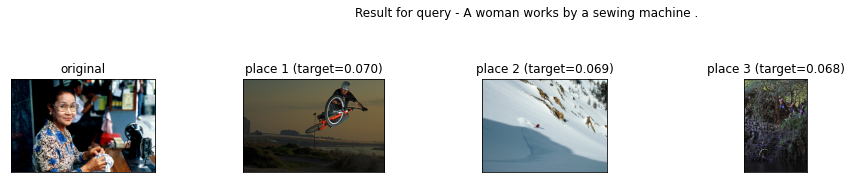

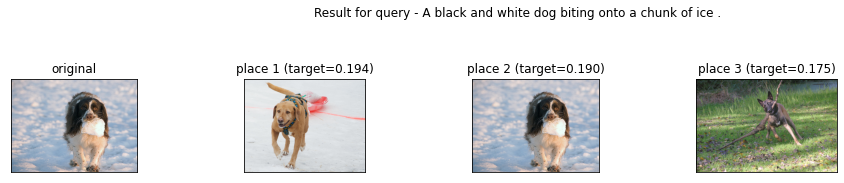

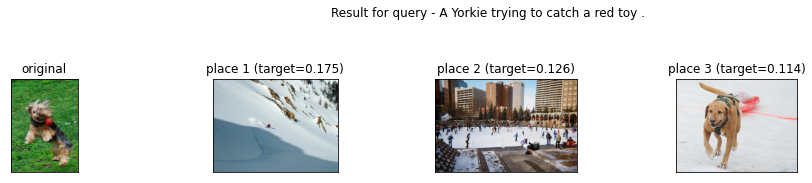

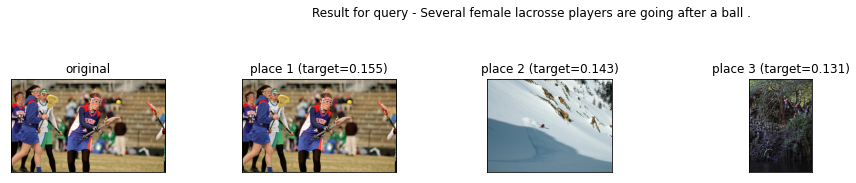

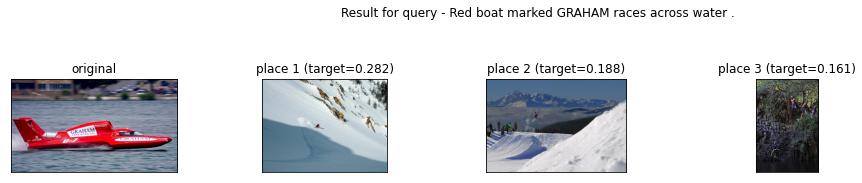

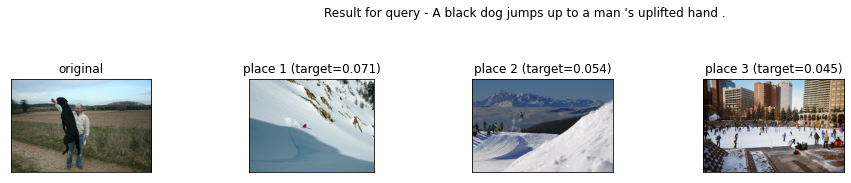

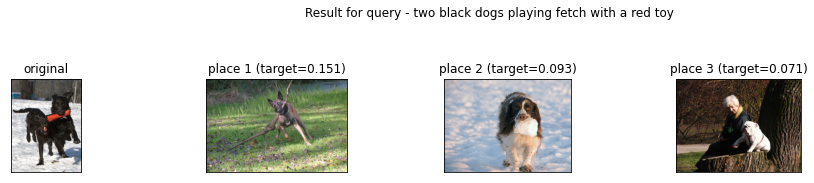

In [ ]:
for index, row in test_image_info.sample(n=10).iterrows():
    search(row['query_text'], row['image'])

**Вывод:** по визуальному сравнению можно сделать вывод, что модель нечасто находит точное соответствие изображения и запроса. Но при этом можно заметить, что в целом выдаются релевантные ответы (если в тексте есть "dog", то с высокой вероятностью все картинки будут содержать изображения собак). Так же выполнена задача по соблюдению законодательства (запрещенные изображения не выводятся и отображается дисклеймер).
Однако, модель все еще показывает неудовлетворительные результаты и требует доработки. На мой взгляд, одна из проблем - дисбаланс классов, в обучающей выборке из 50 тыс. строк было мало положительных совпадений. Стоит попробовать модель CLIP.